# Práctica 1. Clasificación de imágenes utilizando redes convolucionales

El objetivo de esta práctica es resolver el problema de clasificación de dígitos escritos a manos (MNIST). Consiste en clasificar correctamente los dígitos del 0 al 9 a partir de imágenes. Es uno de los problemas más usuales para introducirse en el campo de la clasificación de imágenes con redes neuronales, ya que es relativamente sencillo obtener un buen resultado.

## Importación de las librerías

Es una buena práctica colocar todas las importaciones de librerías al principio de nuestro código. Para este ejercicio solamente nos hará falta utilizar `tensorflow`, `numpy` y `matplotlib`:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split

In [2]:
## Opciones generales de Matplotlib para ajustar las figuras
plt.rcParams['figure.figsize'] = [9, 4]
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
## Este fragmento de código puede servir para solucionar algunos errores de CUDA
try:
    tf_gpus = tf.config.list_physical_devices('GPU')
    for gpu in tf_gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass 

## Carga de los datos

Al ser un problema tan conocido en aprendizaje profundo, la mayoría de librerías incluyen el conjunto de datos para facilitar su acceso. Podemos obtenerlo directamente de la librería TensorFlow con la función `tf.keras.datasets.mnist.load_data()`. Esta función nos devuelve dos conjuntos de datos: el de entrenamiento y el de test.

In [4]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

### Exploración de los datos

Siempre es recomendable inspeccionar los datos con los que vamos a trabajar. Al utilizar imágenes esto es especialmente sencillo, ya que solamente tenemos que representarlas. Las dos cosas en las que deberíamos fijarnos son:

- Las dimensiones de las imágenes.
- El rango de valores de los *píxeles*.
- El formato de las etiquetas.

Para comprobar las dimensiones podemos utilizar el atributo `.shape`, mientras que para observar el rango de valores podemos realizar un histograma o representar la imagen junto a su mapa de color.

Las capas convolucionales que utilizaremos requieren que las imágenes de entrada tengan unas dimensiones determinadas: $(alto, ancho, canales)$. Además, si trabajamos con imágenes muy grandes puede ser recomendable reducir su tamaño para acelerar los cálculos. En este caso, las dimensiones de las imágenes que hemos importado son $(28,28)$. Esto sucede porque las imágenes de este conjunto de datos están en blanco y negro, por lo que solamente tienen un canal y han decidido no incluirlo. Podemos añadir este canal de color utilizando la función `np.expand_dims()`, que permite añadir dimensiones "fantasma" a cualquier `np.array`:

In [5]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

Para observar el rango de valores de las imágenes vamos a optar por representar una de ellas junto a su mapa de color:

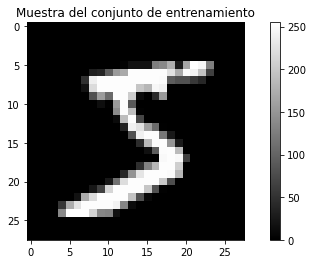

In [6]:
plt.figure()
plt.imshow(X_train[0])
plt.title("Muestra del conjunto de entrenamiento")
plt.colorbar()
plt.savefig("Images/Sample_Colormap.png")
plt.show()

Como se puede ver, los valores de los píxeles están en el rango $[0,255]$. Como las redes neuronales trabajan mejor con datos en el rango $[0,1]$, dividimos por 255 para normalizar todas las imágenes al rango $[0,1]$:

In [8]:
X_train = X_train / 255
X_test = X_test / 255

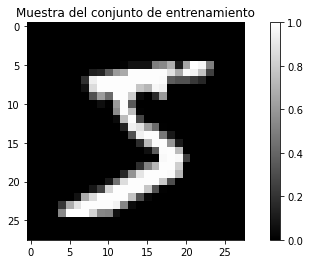

In [9]:
plt.figure()
plt.imshow(X_train[0])
plt.title("Muestra del conjunto de entrenamiento")
plt.colorbar()
plt.savefig("Images/Sample_Colormap_Scaled.png")
plt.show()

Por último nos queda ver en qué formato están las etiquetas. Esto es importante porque, como veremos más adelante, hay que elegir la función de coste en función de si tenemos etiquetas *one-hot* o etiquetas discretas. Lo más sencillo es ver cualquiera de las etiquetas del conjunto:

In [9]:
Y_train[0]

5

Vemos que son números discretos.

### Separación en entrenamiento-validación-test

Para poder ajustar algunos hiperparámetros del modelo es conveniente utilizar también un conjunto de validación, así que tomaremos 10000 muestras del conjunto de entrenamiento y las pasaremos a un nuevo conjunto de validación. De esta forma obtenemos los tres conjuntos con los que vamos a trabajar: 

- Entrenamiento: 50000 muestras.
- Validación: 10000 muestras.
- Test: 10000 muestras.

Hemos elegido esta proporción para que el conjunto de validación y el de entrenamiento tengan el mismo tamaño. Esto es simplemente una forma de asegurarnos de que los resultados que obtengamos en validación puedan ser representativos del test. Podríamos hacer esta división de manera manual, pero hay que asegurarse de que la distribución de las clases se mantiene lo más parecida posible en todos los conjuntos, así que esta división tiene que hacerse de manera estratificada. Esto quiere decir que se tendrá en cuenta la etiqueta de cada imagen para mantener la proporción al hacer la división. La librería `sklearn` tiene implementada la función `sklearn.model_selection.train_test_split()` que permite hacer esta división fácilmente:

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=10000, stratify=Y_train, random_state=42)

X_train.shape, X_val.shape, X_test.shape

((50000, 28, 28, 1), (10000, 28, 28, 1), (10000, 28, 28, 1))

## Definición del modelo

Una vez ya hemos inspeccionado y preparado nuestros datos, solamente nos queda definir el modelo que vamos a utilizar. Se pueden utilizar una gran cantidad de arquitecturas diferentes para un ejercicio de clasificación, pero todas tienen que tener algo en común: la salida del modelo tiene que ser una probabilidad (clasificación binaria, la probabilidad de la clase positiva normalmente) o una distribución de probabilidad (clasificación multi-clase, la probabilidad de pertenecer a cada una de las clases). A la hora de implementarlo, esto quiere decir que nuestra última capa tiene que ser una capa densa (`layers.Dense`) con una o varias neuronas y función de activación sigmoide o softmax respectivamente.

En nuestro caso particular estamos planteando un problema de clasificación multi-clase (tenemos que clasificar entre 10 dígitos distintos), por lo que nuestra última capa será una capa densa de 10 neuronas con activación sigmoid.

Además de la arquitectura, tendremos que elegir una función de coste acorde: la entropía cruzada. TensorFlow implementa dos variantes de esta función de coste: `tf.losses.BinaryCrossentropy()` para el caso binario, y `tf.losses.CategoricalCrossentropy()` (y `tf.losses.SparseCategoricalCrossentropy()`) para el caso multiclase. Llama la atención que haya dos variantes para el caso multi-clase. Esto es porque las funciones cambian dependiendo de cómo introduzcamos las etiquetas al modelo: si utilizamos etiquetas en formato *one-hot* utilizaremos `tf.losses.CategoricalCrossentropy()`, mientras que si nuestras etiquetas son números discretos (0, 1, 2, 3...) utilizaremos `tf.losses.SparseCategoricalCrossentropy()`. Como hemos visto antes, la forma de nuestras etiquetas nos indica que debemos elegir `tf.losses.SparseCategoricalCrossentropy()`.

De cara a la definición de los modelos, Keras permite utilizar tres aproximaciones que difieren en la sencillez y la personalización de los modelos:

- API Secuencial: Es la más sencilla de utilizar pero solo permite definir modelos donde las capas se conectan una detrás de la otra. 
- API Funcional: Permite mucha más flexibilidad que la API Secuencial pero requiere que especifiquemos qué capas se conectan entre sí y cómo lo hacen.
- Herencia de clases: Permite un control total de lo que pasa en el modelo. Solamente nos hará falta utilizarla en casos específicos donde no podamos utilizar las otras dos APIs. Puede dar algunos problemas a la hora de guardar y cargar los modelos.

En general, la mayoría de problemas los podemos afrontar utilizando las dos primeras opciones.

### API Secuencial

La arquitectura que vamos a plantear este ejercicio es muy sencilla, así que podemos utilizar la API Secuencial. Para ello instanciamos un objeto `tf.keras.models.Sequential()`, al cual le pasamos una lista con las capas que queremos que tenga el modelo. Esta clase ajusta automáticamente las dimensiones de las matrices de pesos de cada capa, pero necesita conocer las dimensiones de los datos de entrada. Esta información se la daremos mediante el parámetro `input_shape` en la primera capa. El resto de capas no necesitan este parámetro.

> A modo de apunte, `kernel_size` como `pool_size` pueden tomar tanto valores únicos como tuplas `(d1, d2)`. Si introducimos un único valor `d`, lo tomará internamente como una tupla `(d,d)`. Esto quiere decir que utilizaremos tamaños de kernel y pooling simétricos. Si queremos utilizar alguno que no sea simétrico tendremos que introducir directamente `(d1, d2)`.

In [11]:
model = tf.keras.models.Sequential([
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28,28,1)),
    layers.MaxPool2D(pool_size=2),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
    layers.MaxPool2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(10, activation="softmax")
])

Una vez hemos definido la arquitectura del modelo, tendremos que compilarlo para especificar una función de coste (que ya hemos explicado antes), un optimizador (lo estándar suele ser elegir *Adam*) y las métricas que queremos monitorizar durante el entrenamiento (precisión en este caso). Además, podemos utilizar el método `.summary()` para obtener un resumen del modelo que hemos creado. También podemos utilizar la función `tf.keras.utils.plot_model()` para obtener un resumen más visual, aunque requiere de la instalación de algunas otras librerías externas.

Podemos utilizar tanto las versiones "objeto" de los optimizadores y las funciones de pérdida como sus nombres asociados. Al utilizar los nombres no podremos cambiar parámetros como el *learning rate*, pero es suficiente para este ejercicio.

**Ejercicio: Utiliza los objetos `tf.optimizers.Adam()` y `tf.losses.SparseCategoricalCrossentropy()` y cambia alguno de sus parámetros, por ejemplo el *learning rate*.**

In [12]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                16010     
Total params: 34,826
Trainable params: 34,826
Non-trainable params: 0
____________________________________________________

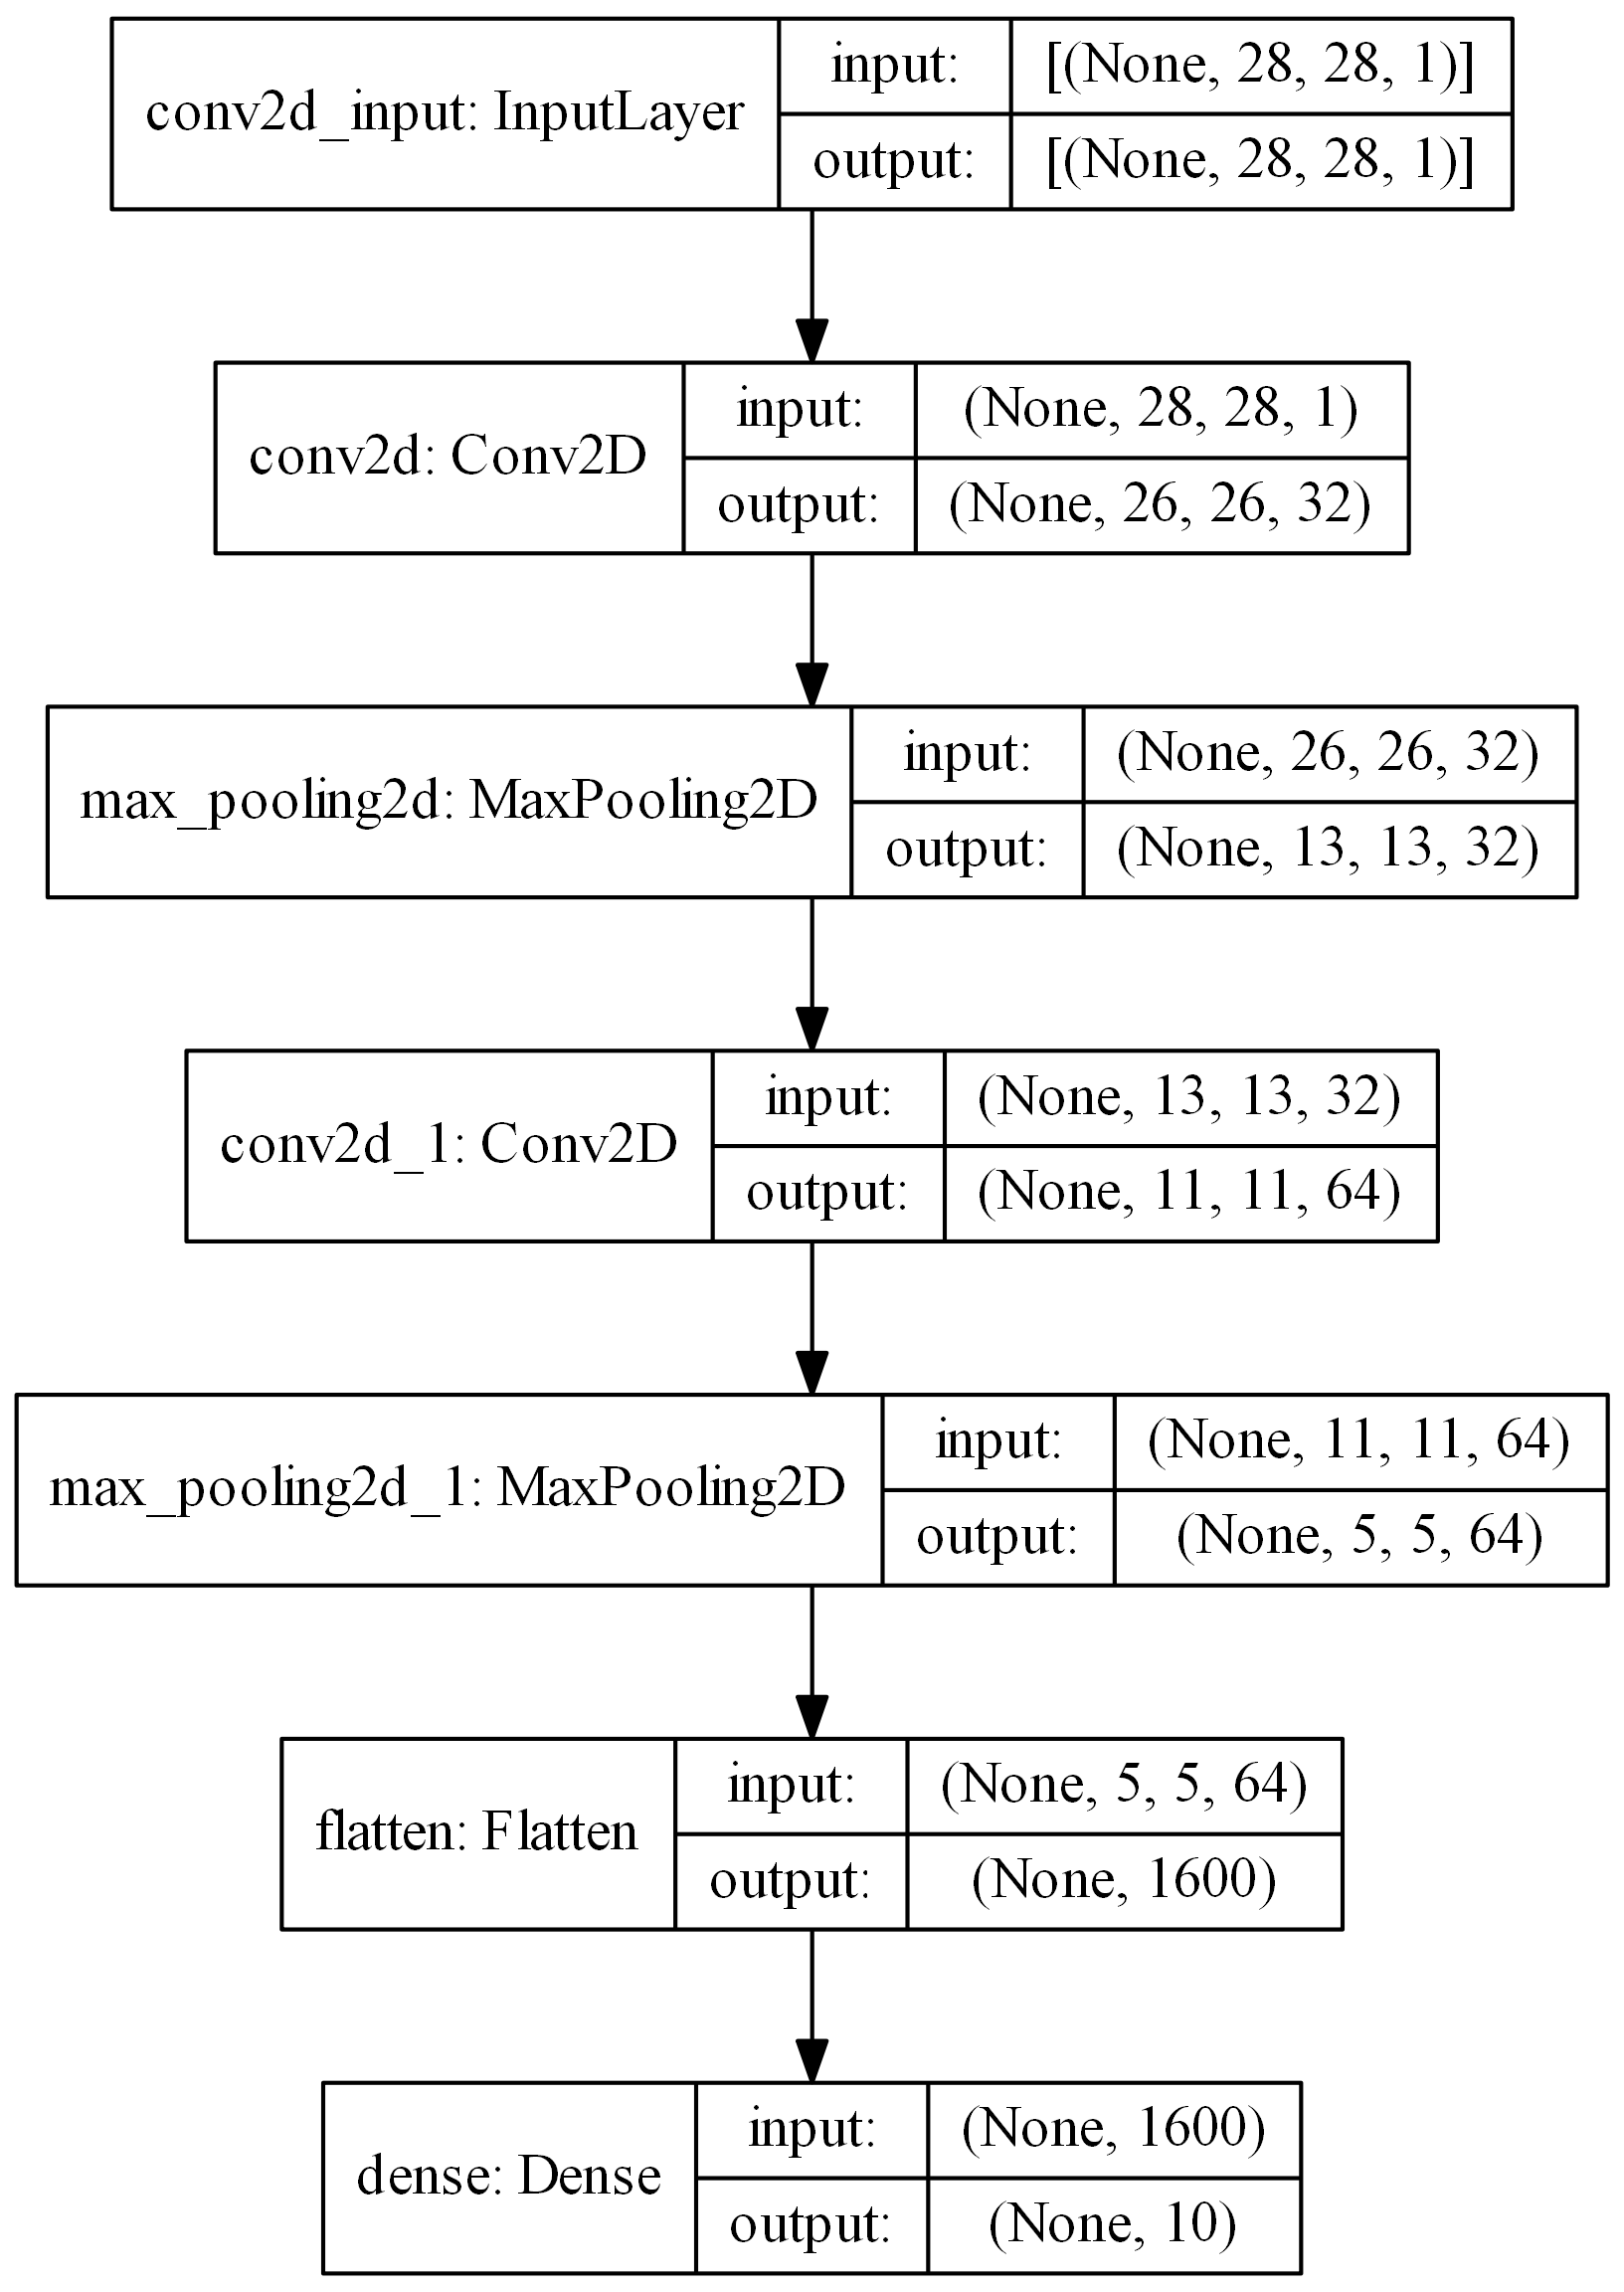

In [14]:
plot_model(model,show_shapes=True,dpi=300)

### API Funcional

**Define el mismo modelo pero utilizando la API Funcional.**

In [16]:
# ## SOLUCIÓN ##

# ## Definimos la entrada al modelo
# x = tf.keras.Input(shape=(28,28,1))

# ## Definimos las capas que tendrá
# conv1 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")
# conv2 = layers.Conv2D(filters=64, kernel_size=3, activation="relu")
# maxp1 = layers.MaxPool2D(pool_size=2)
# maxp2 = layers.MaxPool2D(pool_size=2)
# dense_final = layers.Dense(10, activation="softmax")

# ## Finalmente definimos el recorrido de los datos en la red
# output = conv1(x)
# output = maxp1(output)
# output = conv2(output)
# output = maxp2(output)
# output = layers.Flatten()(output)
# output = dense_final(output)

# ## Y terminamos por definir el modelo completo
# model = tf.keras.Model(x, output)
# model.summary()

## Entrenamiento del modelo

Llegados hasta aquí solo resta utilizar el método `.fit()` del modelo para entrenarlo. Este método nos permite utilizar un conjunto de validación, `validation_data`, durante el entrenamiento para observar cómo de bien generaliza nuestro modelo. Esto resulta muy útil cuando queremos utilizar técnicas más avanzadas como *early stopping* que detienen el entrenamiento cuando empezamos a sobreajustar al conjunto de entrenamiento.

Los parámetros `batch_size` y `epochs` hacen referencia a la cantidad de imágenes que se utilizarán para cada ajuste de los pesos y las veces que recorremos el conjunto de datos respectivamente. Normalmente se recomienda utilizar un `batch_size` lo más grande posible para exprimir al máximo el hardware y acelerar el entrenamiento, aunque vale la pena experimentar con distintos valores porque está estrechamente relacionado con el *learning rate*. El parámetro `verbose` indica la cantidad de información que queremos ver por pantalla durante el entrenamiento. Es interesante en modelos que se entrenan rápido como este, pero en modelos con entrenamientos largos o con muchas épocas no será demasiado útil.

Además, el método `.fit()` devuelve un objeto particular que permite acceder a todas las métricas que se han calculado durante el entrenamiento. Es muy útil para representar las dinámicas de entrenamiento del modelo.

In [15]:
history = model.fit(X_train, Y_train, 
                    batch_size=64, epochs=10, 
                    validation_data=(X_val, Y_val))

Epoch 1/10
782/782 [==============================] - 12s 6ms/step - loss: 0.5272 - accuracy: 0.8470 - val_loss: 0.0858 - val_accuracy: 0.9760
Epoch 2/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0734 - accuracy: 0.9783 - val_loss: 0.0685 - val_accuracy: 0.9799
Epoch 3/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0521 - accuracy: 0.9843 - val_loss: 0.0590 - val_accuracy: 0.9824
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0417 - accuracy: 0.9867 - val_loss: 0.0532 - val_accuracy: 0.9834
Epoch 5/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0334 - accuracy: 0.9902 - val_loss: 0.0496 - val_accuracy: 0.9868
Epoch 6/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0287 - accuracy: 0.9910 - val_loss: 0.0457 - val_accuracy: 0.9868
Epoch 7/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0214 - accuracy: 0.9935 - val_loss: 0.0484 - val_accuracy: 0.9864
Epoch

Una vez completado el entrenamiento representamos las dinámicas de entrenamiento a partir de `history`. De forma sencilla, `history` tiene un atributo `.history`, que es un diccionario usual de Python, dónde se guardan los diferentes valores de las métricas que se muestran durante el entrenamiento.

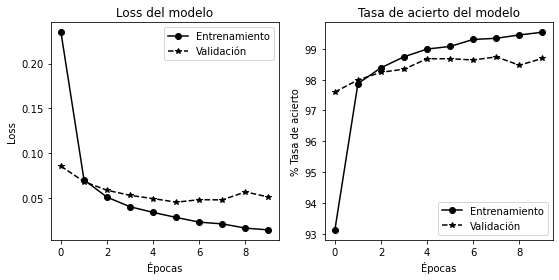

In [17]:
plt.figure()

plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'k-o', label = "Entrenamiento")
plt.plot(history.history['val_loss'], 'k--*', label = "Validación")
plt.ylabel('Loss')
plt.xlabel('Épocas')
plt.title('Loss del modelo')
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.array(history.history['accuracy'])*100, 'k-o', label="Entrenamiento")
plt.plot(np.array(history.history['val_accuracy'])*100, 'k--*', label="Validación")
plt.ylabel('% Tasa de acierto')
plt.xlabel('Épocas')
plt.title('Tasa de acierto del modelo')
plt.legend()
plt.savefig("Images/Training_CNN.png")
plt.show()

De la figura superior podemos extraer dos conclusiones:

- El modelo parece adecuado para resolver esta tarea: ha sido capaz de aprenderse el conjunto de entrenamiento. Esto que parece una obviedad es algo importante. Cuando nos enfrentamos a un problema nuevo es posible que no tengamos claro, por ejemplo, cómo de grande tendrá que ser nuestro modelo. Una forma de descubrirlo puede ser intentar sobreajustar primero al conjunto de entrenamiento y ver si es capaz de aprendérselo, esto nos dirá si el modelo parece adecuado para la tarea que tenemos que resolver. Una vez tengamos esto claro ya pasamos a la fase de ajuste donde intentamos obtener el mejor resultado posible en validación.

- Se produce un cierto sobreajuste apreciable porque las gráficas de entrenamiento y validación se separan conforme aumentan las épocas. Para tratar de resolver estos problemas podemos utilizar técnicas de regularización(L1, L2 y Dropout), técnicas de aumento de datos, etc. 

Antes de acabar restarían hacer dos cosas:

- Evaluar nuestro modelo en el conjunto de test.

- Guardar el modelo final para poder utilizarlo en otras ocasiones sin necesidad de volverlo a entrenar.

### Evaluación del modelo

El método `.evaluate()` permite calcular todas las métricas que hemos compilado anteriormente en el modelo sobre el conjunto de datos que queramos. Es una buena práctica evaluar el modelo en los diferentes conjuntos de datos al acabar el entrenamiento para obtener una métrica final del trabajo realizado. Este método nos devuelve una lista con las métricas, en este caso la función de coste y la precisión:

In [32]:
eval_train = model.evaluate(X_train, Y_train, verbose=0)
eval_val = model.evaluate(X_val, Y_val, verbose=0)
eval_test = model.evaluate(X_test, Y_test, verbose=0)

print("[Entrenamiento] Loss: {:0.3f} | Accuracy: {:0.3f}".format(*eval_train))
print("[Validación] Loss: {:0.3f} | Accuracy: {:0.3f}".format(*eval_val))
print("[Test] Loss: {:0.3f} | Accuracy: {:0.3f}".format(*eval_test))

[Entrenamiento] Loss: 0.010 | Accuracy: 0.997
[Validación] Loss: 0.048 | Accuracy: 0.987
[Test] Loss: 0.036 | Accuracy: 0.989


Así podemos ver que el modelo rinde ligeramente mejor en el conjunto de test que en el de validación. En líneas generales, hemos obtenido un resultado muy bueno y podemos considerar el problema como resuelto.

### Guardar el modelo

En este ejercicio el modelo utilizado es relativamente rápido de entrenar, pero en problemas reales podemos encontrar tiempos de ejecución mucho más largos. Esto quiere decir que es muy importante saber guardar el modelo una vez ha sido entrenado para poder utilizarlo sin tener que repetir el entrenamiento cada vez. Para ello podemos utilizar el método `.save()`. Hay varias formas posibles de guardar los modelos, aunque la más sencilla es guardarlos en formato `.h5`:

In [33]:
model.save("model_cnn_mnist.h5")

Una vez guardado podemos volver a cargarlo con la función `tf.keras.models.load_model()` y utilizarlo normalmente:

In [35]:
model_loaded = tf.keras.models.load_model("model_cnn_mnist.h5")

Podemos comprobar que obtenemos los mismos resultados que obteníamos antes:

In [36]:
eval_train = model_loaded.evaluate(X_train, Y_train, verbose=0)
eval_val = model_loaded.evaluate(X_val, Y_val, verbose=0)
eval_test = model_loaded.evaluate(X_test, Y_test, verbose=0)

print("[Entrenamiento] Loss: {:0.3f} | Accuracy: {:0.3f}".format(*eval_train))
print("[Validación] Loss: {:0.3f} | Accuracy: {:0.3f}".format(*eval_val))
print("[Test] Loss: {:0.3f} | Accuracy: {:0.3f}".format(*eval_test))

[Entrenamiento] Loss: 0.010 | Accuracy: 0.997
[Validación] Loss: 0.048 | Accuracy: 0.987
[Test] Loss: 0.036 | Accuracy: 0.989


Vamos a instalar keract que nos ayudará a visualizar los pesos de las diferentes capas de la red

In [59]:
!pip install keract

In [60]:
from keract import get_activations, display_activations, get_gradients_of_trainable_weights, get_gradients_of_activations,display_heatmaps

a = get_activations(model, X_test[:1])  # Con el primer ejemplo del conjunto de test
display_activations(a, directory='mnist_activations', save=True)

conv2d_2_input (1, 28, 28, 1) 
conv2d_2 (1, 26, 26, 32) 
max_pooling2d_2 (1, 13, 13, 32) 
conv2d_3 (1, 11, 11, 64) 
max_pooling2d_3 (1, 5, 5, 64) 
flatten_1 (1, 1600) 
dropout_1 (1, 1600) 
dense_1 (1, 10) 


Pesos de la red por capas:

1. En la primera imagen ve los datos de entrada
2. Luego vendría la primera Convolución
3. Luego la capa de Max pooling, para reducir el tamaño de la imagen (reduce información)
4. Luego ya en la siguiente Convolución y Max pooling ya puedes ver como se aprenden características abstractas
5. Después vendría la capa de aplanamiento (Flatten), para pasar de información multidimensional a unidimensional
6. Capa dropout, y finalmente los datos llegan a la capa Softmax para producir las predicciones

conv2d_2_input (1, 28, 28, 1) 


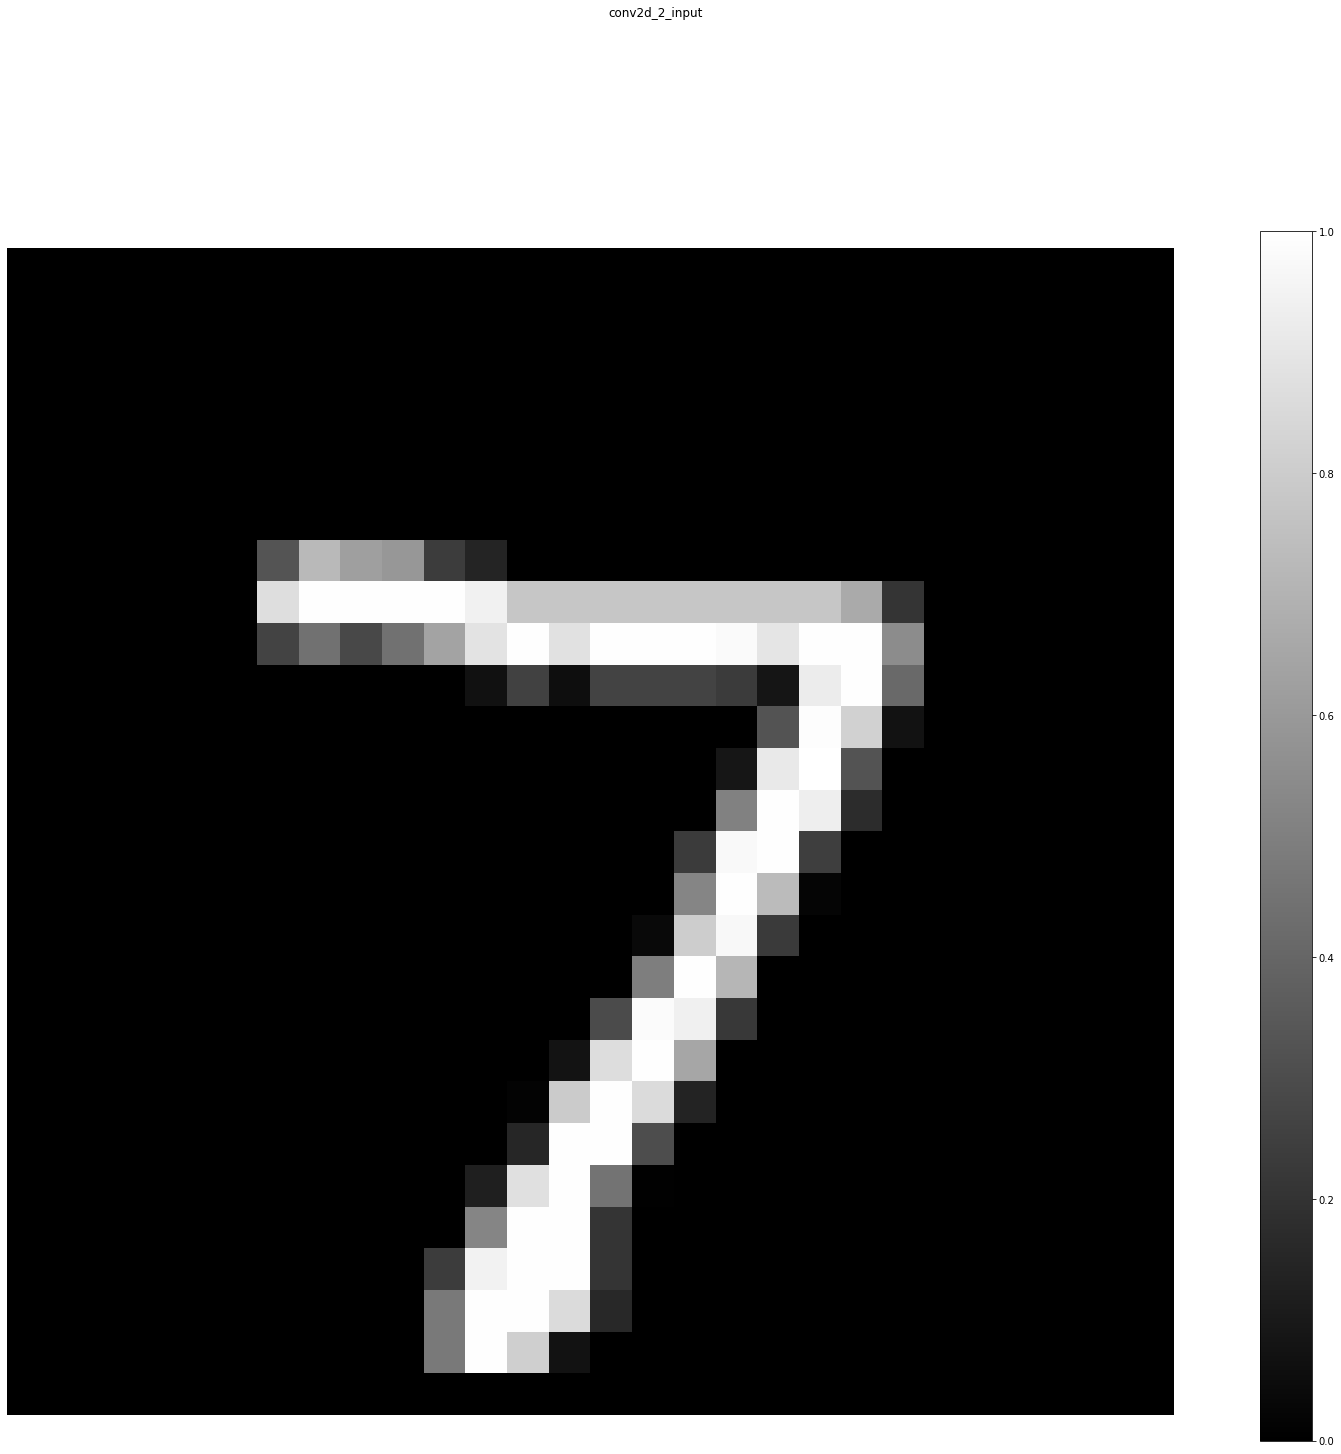

conv2d_2 (1, 26, 26, 32) 


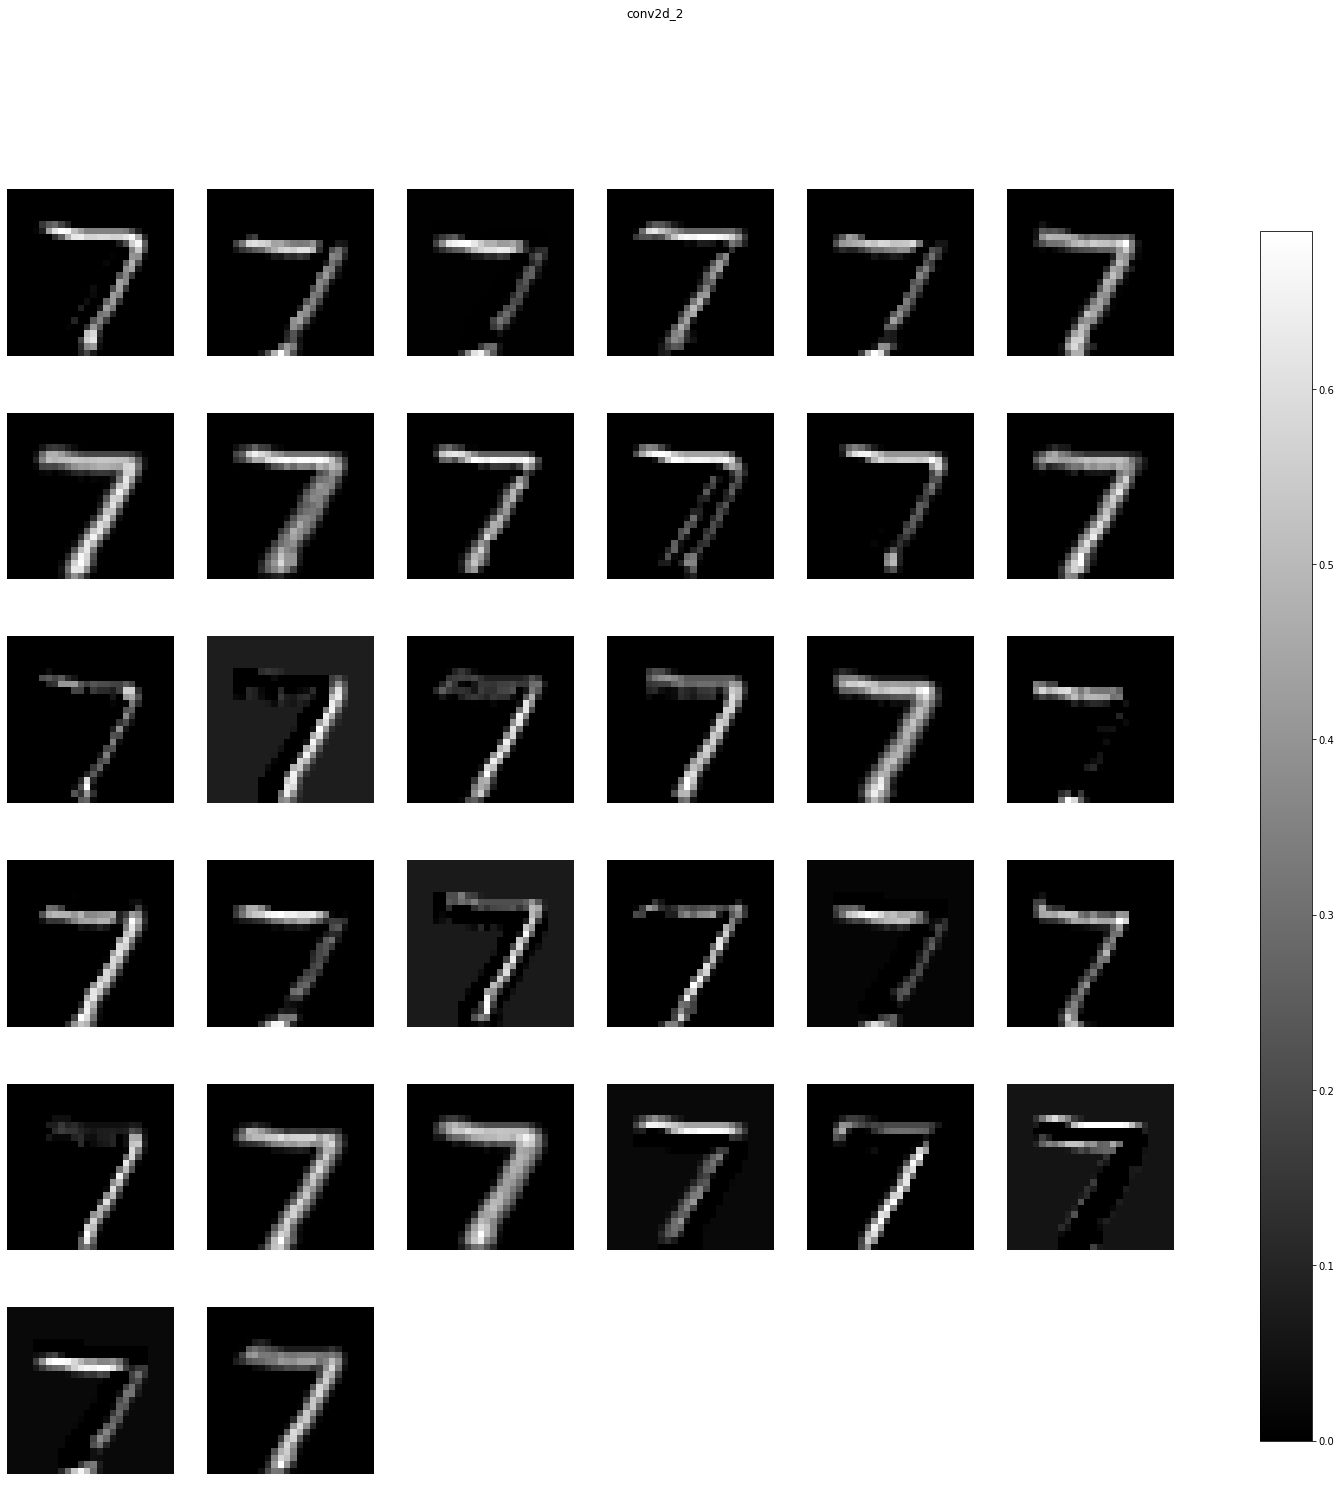

max_pooling2d_2 (1, 13, 13, 32) 


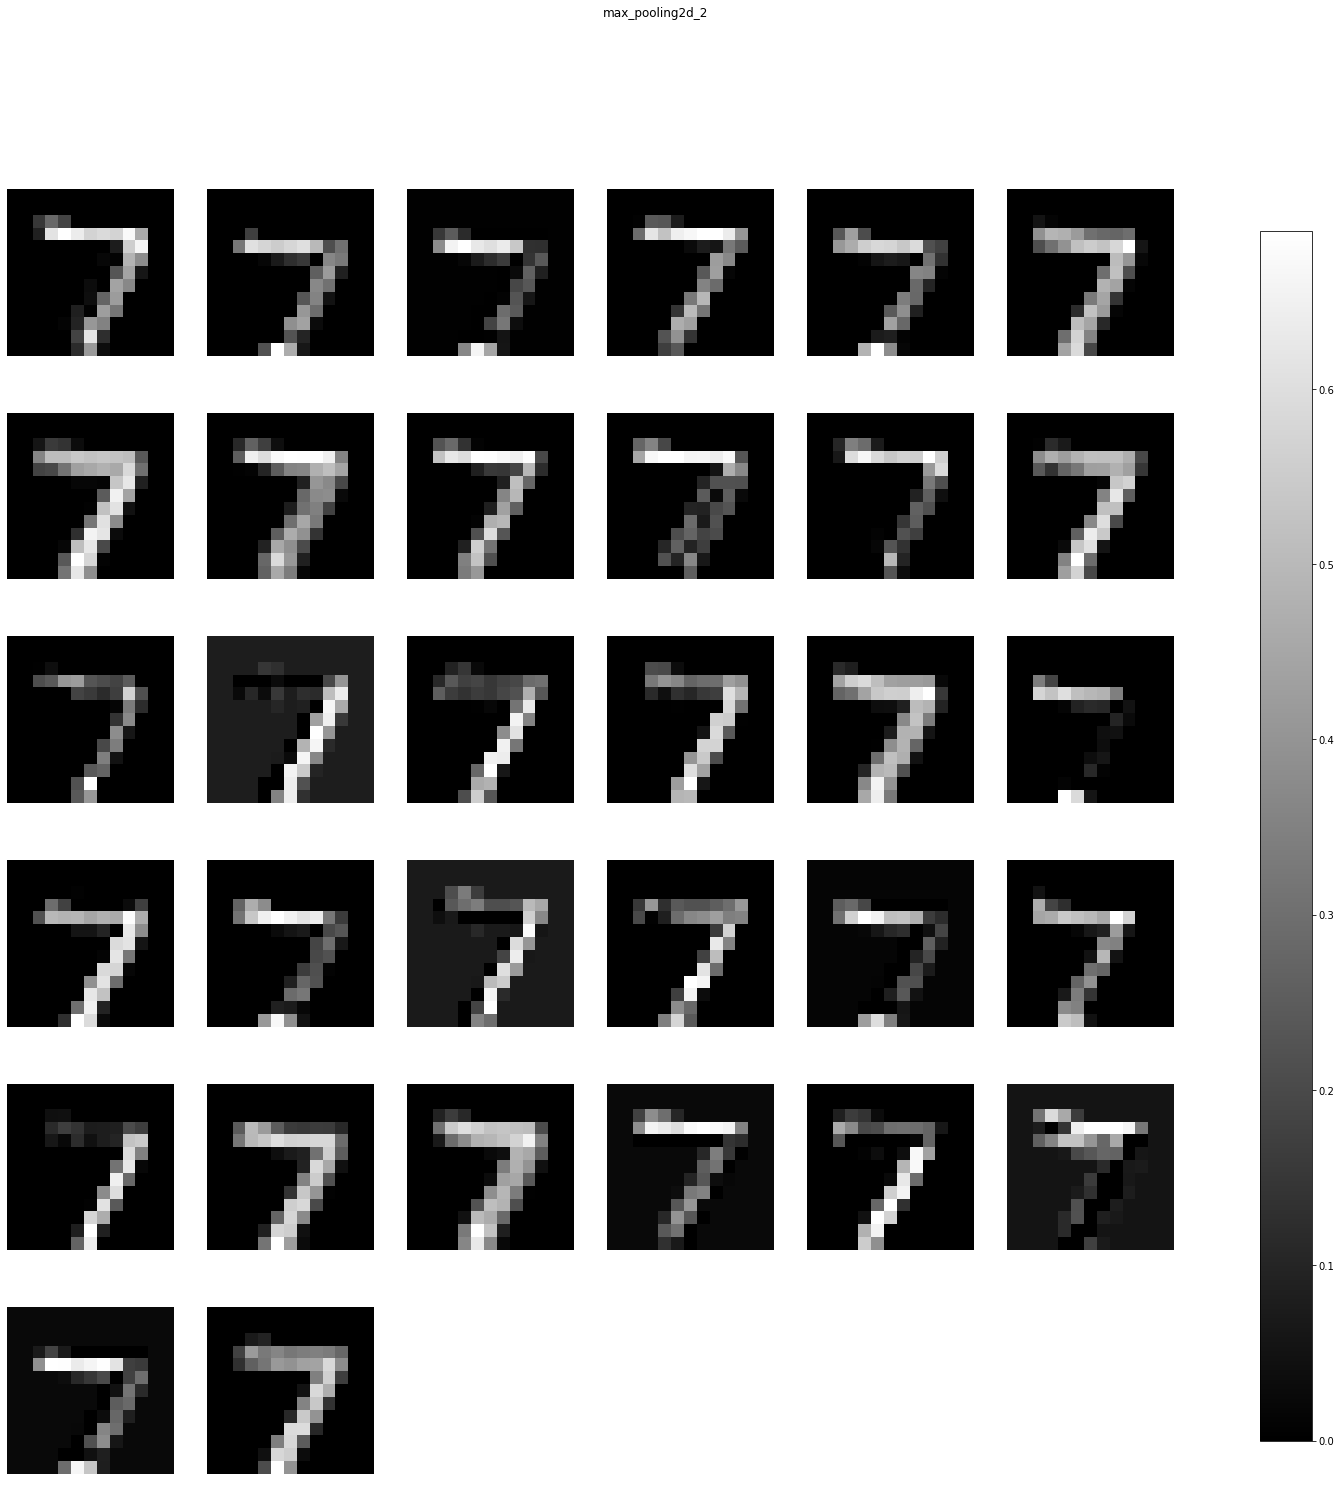

conv2d_3 (1, 11, 11, 64) 


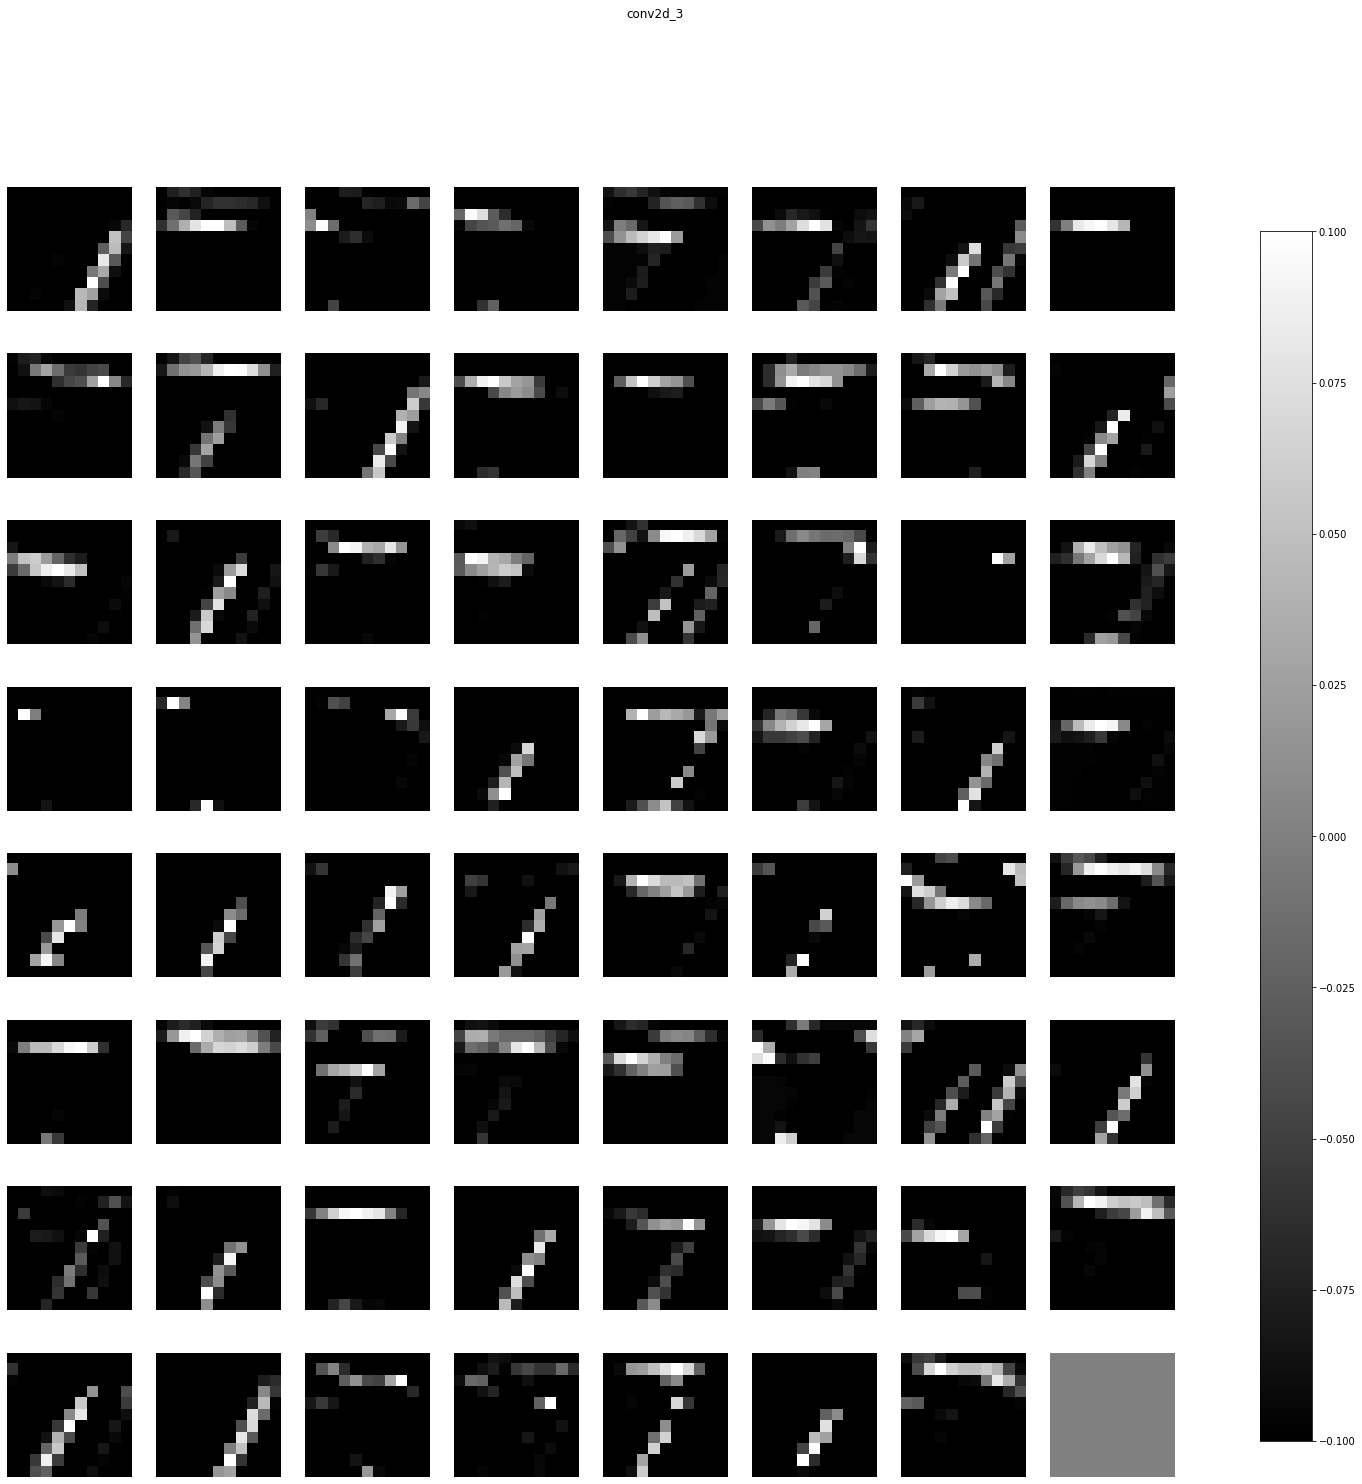

max_pooling2d_3 (1, 5, 5, 64) 


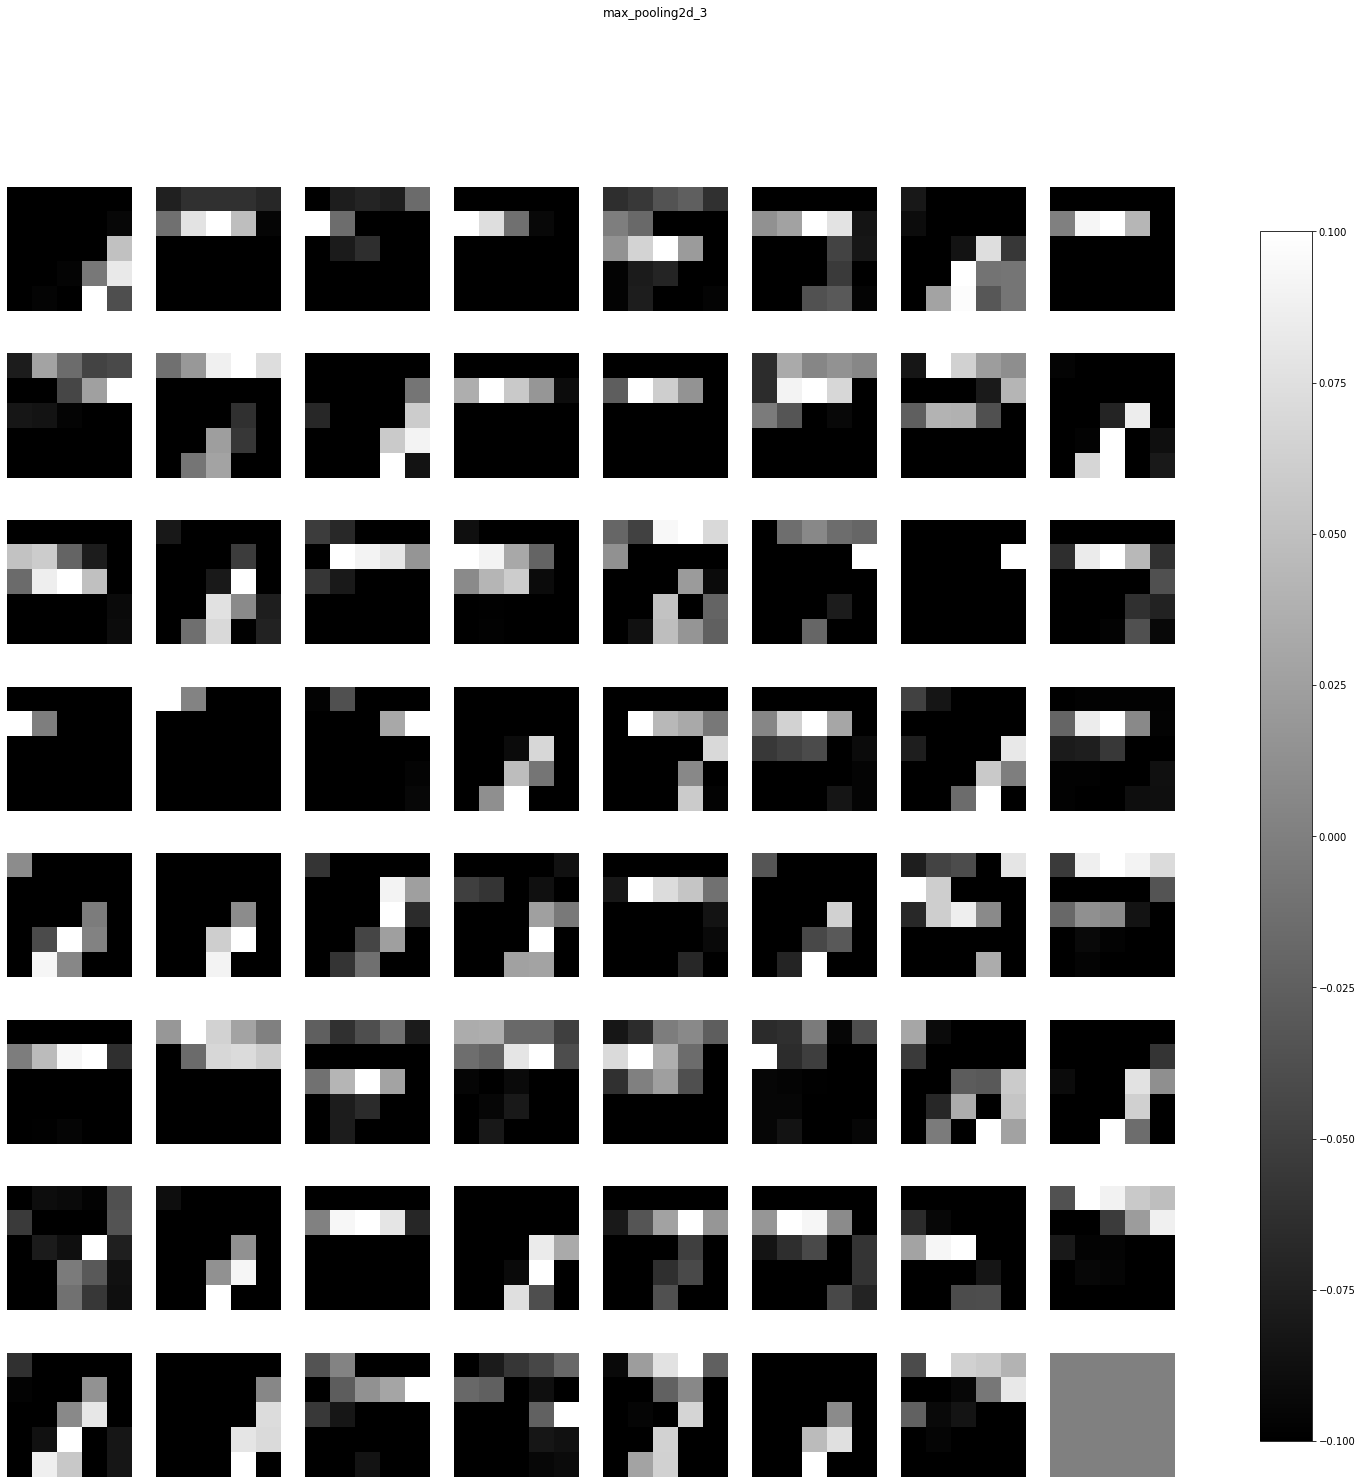

flatten_1 (1, 1600) 


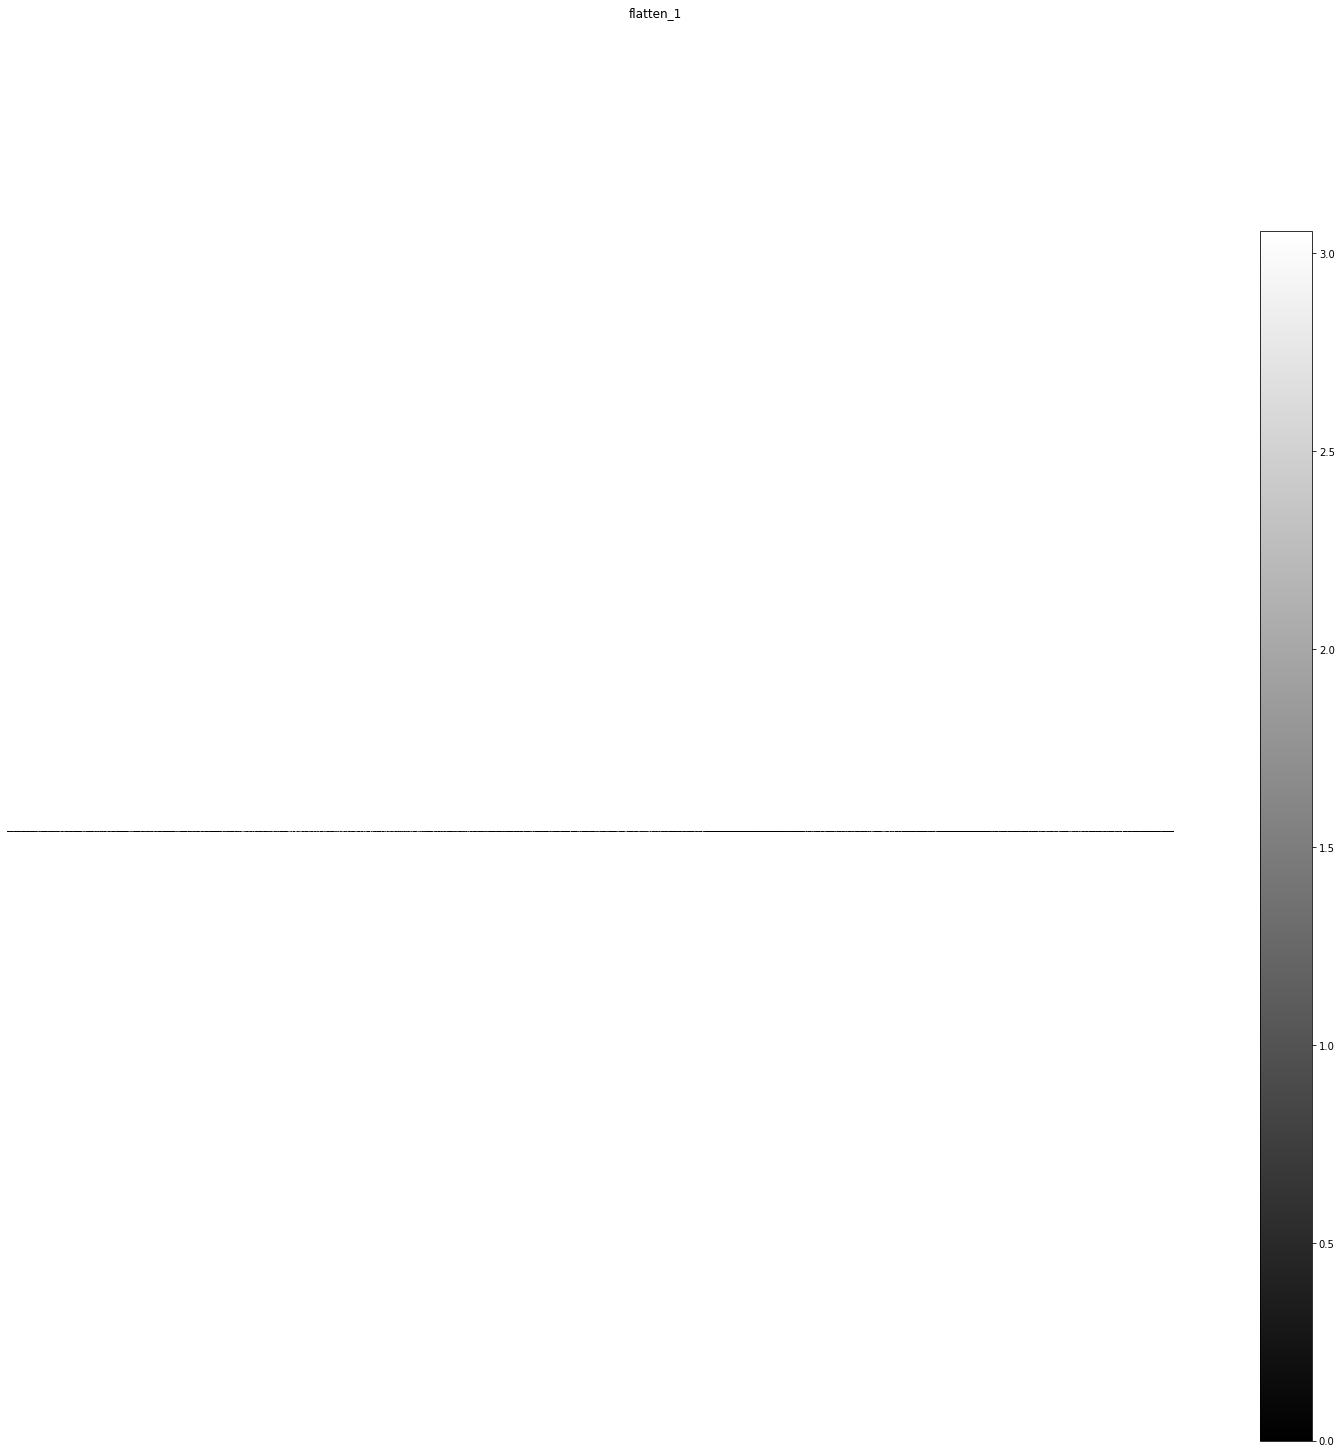

dropout_1 (1, 1600) 


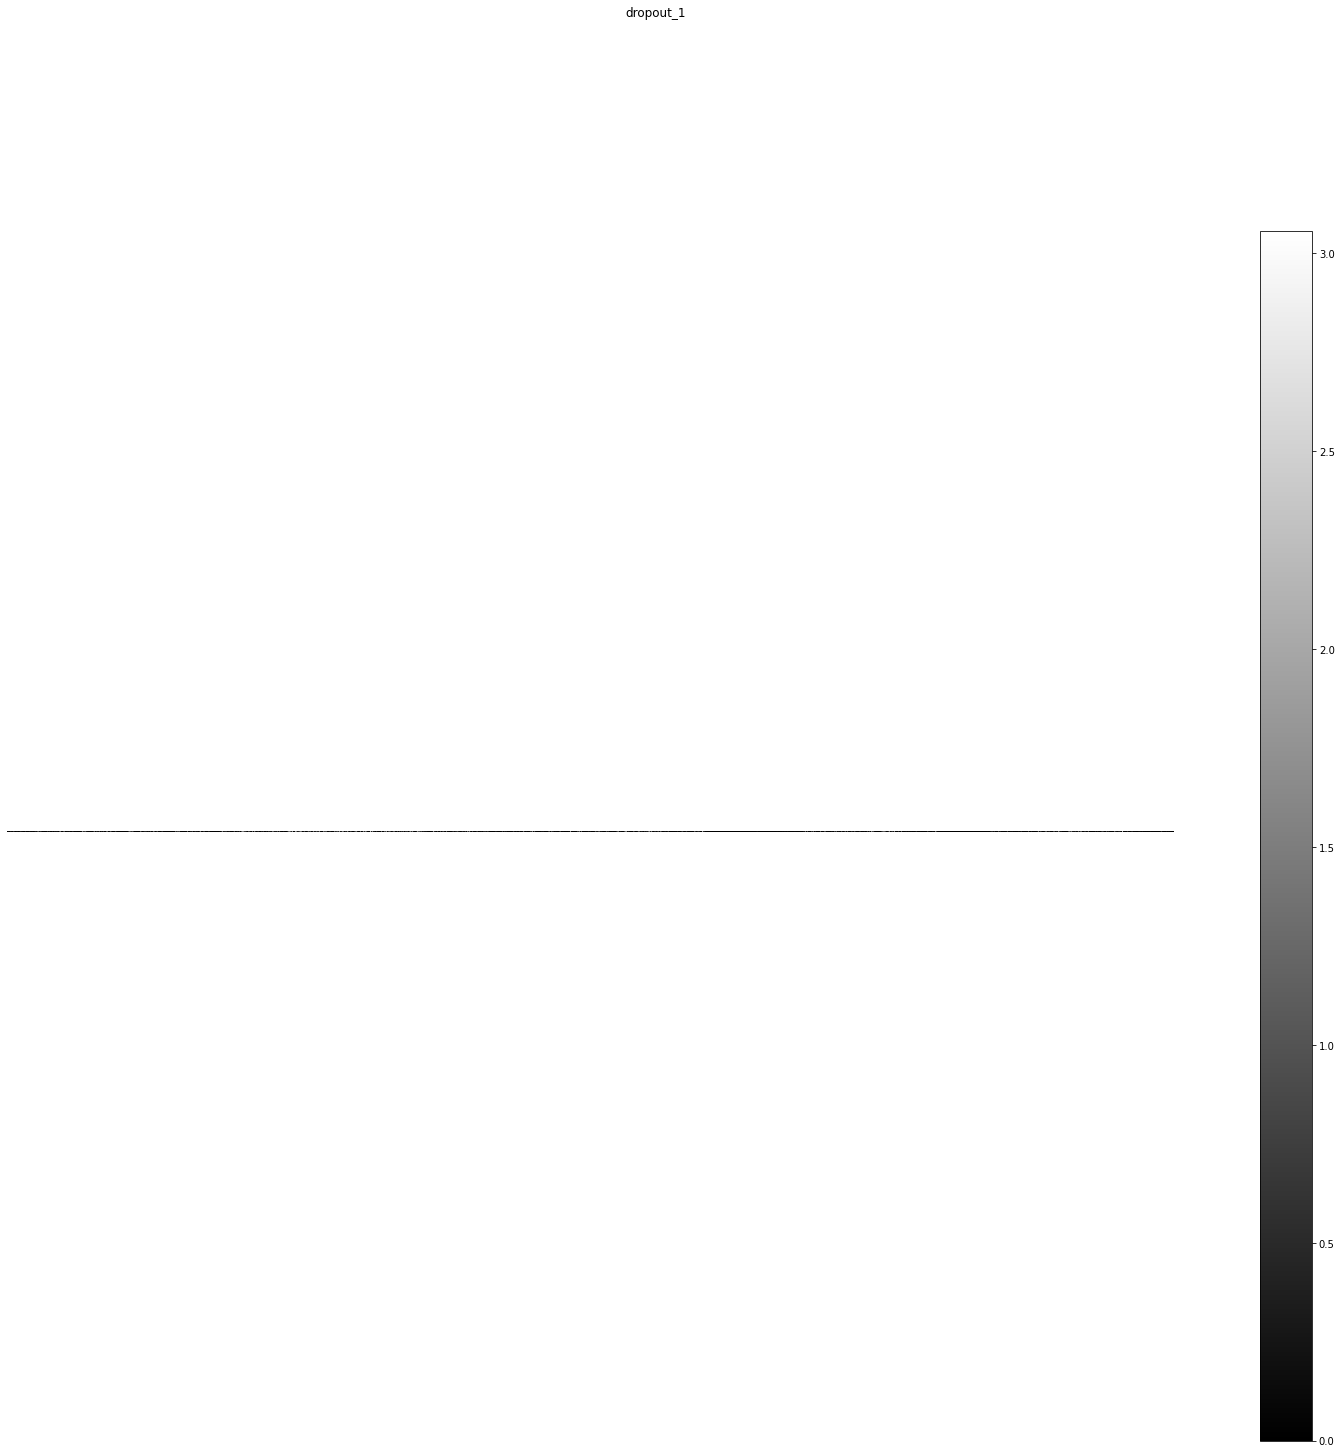

dense_1 (1, 10) 


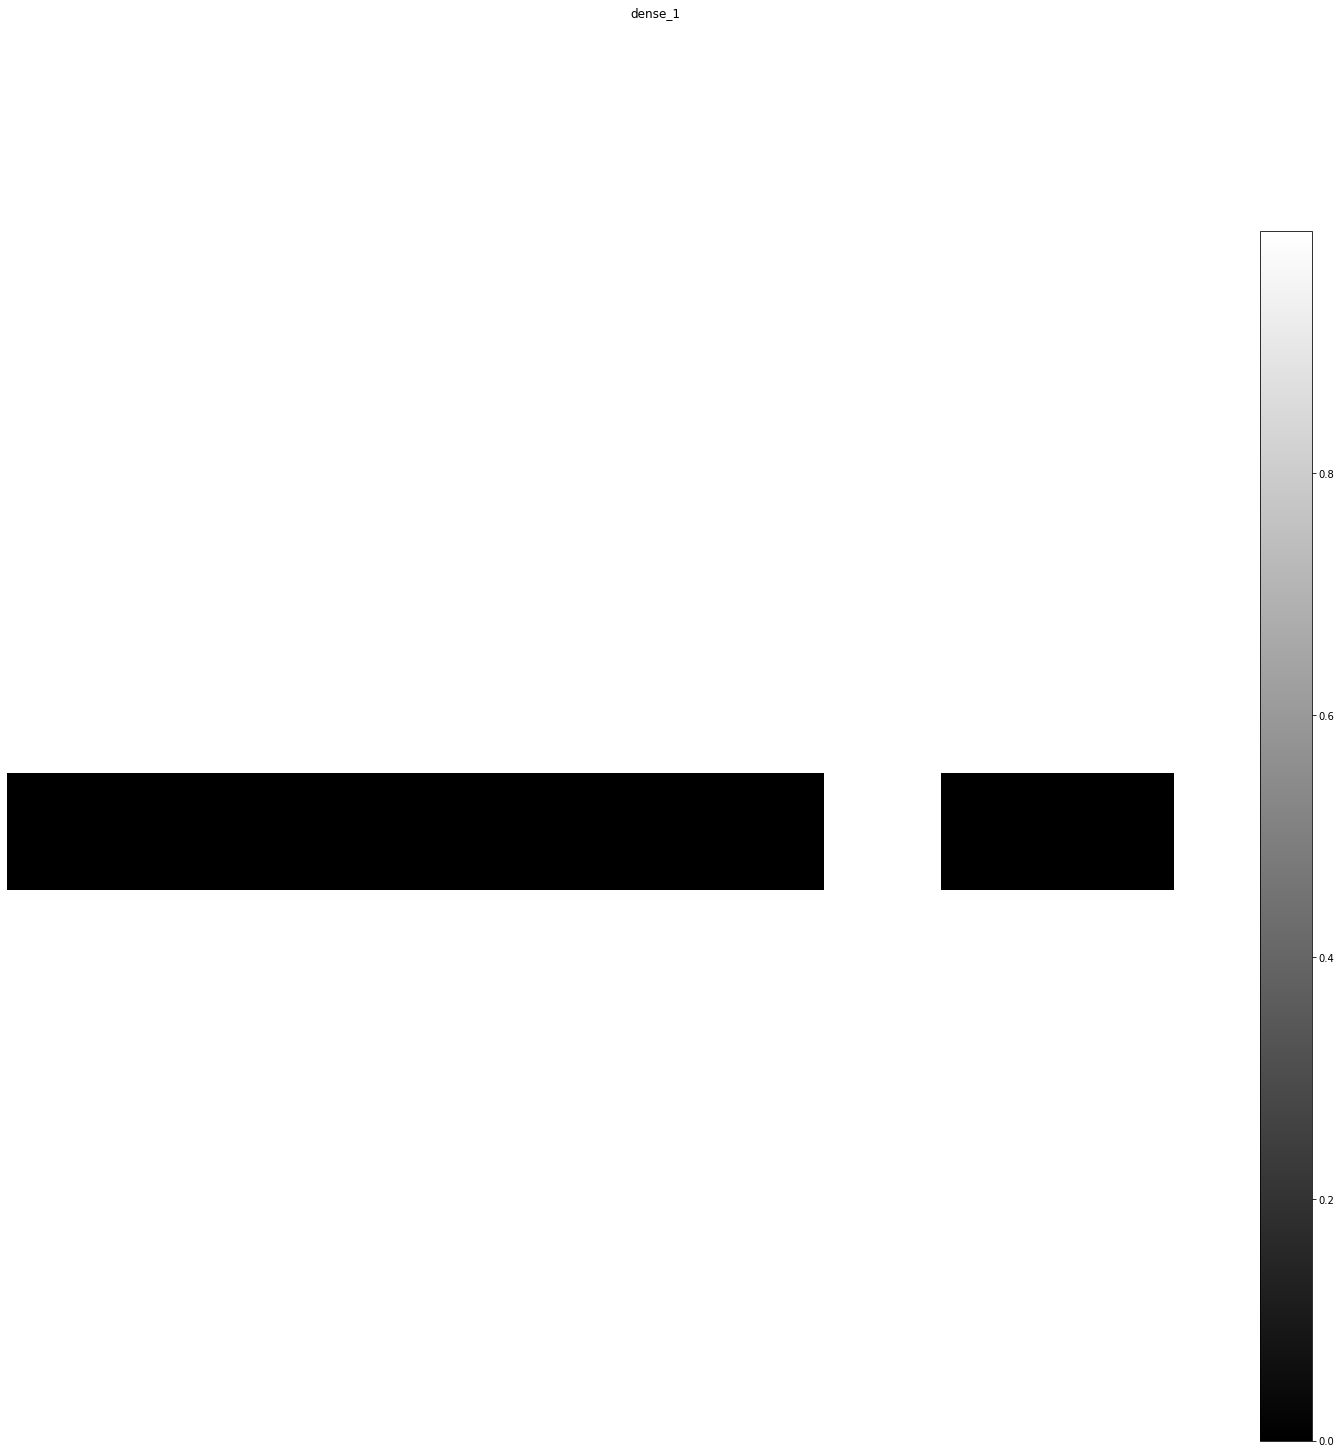

In [61]:
keract_inputs = X_test[:1]
keract_targets = y_test[:1]
activations = get_activations(model, keract_inputs)
display_activations(activations, cmap="gray", save=False)

In [62]:
# activations = get_activations(model, keract_inputs)
# display_heatmaps(activations, keract_inputs, save=False)

Vamos a calcular el score en el conjunto de test, como hemos visto anteriormente el Checkpoint lo monitorizamos en base al conjunto de validación, así que para no hacer "trampas" lo particionamos en tres conjuntos, sino en cierto modo estarías adaptando el ajuste del modelo a datos ya conocidos.

In [63]:
score = model.evaluate(X_test,y_test)
score

[0.03211513087954372, 0.9887]

In [64]:
# Predecimos en test
preds_test = model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


['p(y=0|x) = 0.0000', 'p(y=1|x) = 0.0000', 'p(y=2|x) = 0.9999', 'p(y=3|x) = 0.0000', 'p(y=4|x) = 0.0000', 'p(y=5|x) = 0.0000', 'p(y=6|x) = 0.0000', 'p(y=7|x) = 0.0000', 'p(y=8|x) = 0.0000', 'p(y=9|x) = 0.0000']


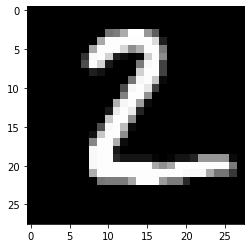

In [65]:
import numpy as np
# Elegimos una imagen de test
idx_mostrar = 1
# Mostramos la imagen
plt.imshow(np.squeeze(X_test[idx_mostrar,:,:,]),cmap="gray")
# Mostramos las probabilidades que da el modelo a cada clase
print(["p(y=%d|x) = %.4f"%(i,p) for i,p in enumerate(preds_test[idx_mostrar])])